In [1]:
import pandas as pd
import numpy as np
import requests
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
plt.style.use("seaborn")

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Defining Features and Classifier

In [2]:
df_multi = pd.read_csv("Fire_multi.csv", index_col=False)

In [3]:
df_multi.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
0,2596,51,3,258,0,510,221,232,148,0,5,29


In [4]:
X = df_multi.drop("Horizontal_Distance_To_Fire_Points",axis=1)
y = df_multi["Horizontal_Distance_To_Fire_Points"]

In [5]:
#Splitting the set (test = 0.3) in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,stratify=y, random_state=4444)

In [6]:
#scaling the features
sca = StandardScaler()
X_train_sca = sca.fit_transform(X_train)
X_test_sca = sca.transform(X_test);

In [7]:
def alg_class(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    print("Accuracy_train: " + str(estimator.score(X_train, y_train)))
    print("Accuracy_test: " + str(accuracy_score(y_pred,y_test)))    

### Apply bagging classifier

In [12]:
#Trying with default parameters
alg_class(BaggingClassifier(base_estimator=DecisionTreeClassifier()), X_train_sca, y_train, X_test_sca, y_test)

Accuracy_train: 0.9975043520166803
Accuracy_test: 0.9493069579585093


In [13]:
acc_test_d = []
acc_train_d = []
depth_ = []
for depth in range(1, 31) :
    bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth), n_estimators=50, n_jobs=-1)
    bg.fit(X_train_sca, y_train)
    y_pred = bg.predict(X_test_sca)
    acc_train_d.append(bg.score(X_train_sca, y_train))
    acc_test_d.append(accuracy_score(y_pred,y_test))  
    depth_.append(depth)

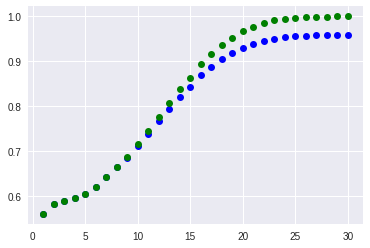

In [14]:
plt.plot(depth_,acc_test_d,"bo")
plt.plot(depth_,acc_train_d,"go");

In [ ]:
acc_test_e = []
acc_train_e = []
n_estimators_ = []
for n_estimators in range(10,220,20) :
    bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=25), n_estimators=n_estimators, n_jobs=-1)
    bg.fit(X_train_sca, y_train)
    y_pred = bg.predict(X_test_sca)
    acc_train_e.append(bg.score(X_train_sca, y_train))
    acc_test_e.append(accuracy_score(y_pred,y_test))  
    n_estimators_.append(n_estimators)

In [ ]:
plt.plot(n_estimators_,acc_test_e,"bo")
plt.plot(n_estimators_,acc_train_e,"go");

In [ ]:
def grid_estimator(estimator, param_grid, X_train, y_train, X_test, y_test, cv=5):
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, n_jobs=1)
    grid.fit(X_train, y_train)
    print("Accuracy training: " + str(grid.best_score_))
    y_pred = grid.predict(X_test)
    print("Accuracy test: " + str(accuracy_score(y_pred,y_test)))
    print(grid.best_estimator_)

### Selecting features determined to be important by Random Forest

In [11]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_in = X[col_in]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]

In [ ]:
sca = StandardScaler()
X_train_in_sca = sca.fit_transform(X_train_in)
X_test_in_sca = sca.transform(X_test_in);

In [14]:
bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30), n_estimators=200, n_jobs=1)
bg.fit(X_train_in_sca, y_train)
y_pred = bg.predict(X_test_in_sca)

In [19]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

Recall for cover:
Type 0:95.79893262783378
Type 1:92.22110873890753
Type 2:83.70966833718114


In [20]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:94.67290246238801
Type 1:92.27471553340212
Type 2:88.72045834328001


In [12]:
bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15), n_estimators=400, n_jobs=1)
bg.fit(X_train_in_sca, y_train)
y_pred = bg.predict(X_test_in_sca)

In [13]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

Recall for cover:
Type 0:92.84427313780049
Type 1:77.40258231304374
Type 2:55.712596429979165


In [14]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:81.97442609746275
Type 1:83.97516702382453
Type 2:85.88541666666667


In [15]:
bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=200), n_estimators=400, n_jobs=1)
bg.fit(X_train_in_sca, y_train)
y_pred = bg.predict(X_test_in_sca)

In [16]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

Recall for cover:
Type 0:95.82744149979473
Type 1:92.2646798251347
Type 2:83.83354918632806


In [17]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:94.74271669522865
Type 1:92.30221576462041
Type 2:88.70881248882797
